# RQ1 additional results

A common assertion in the transfer learning community is that the more the source and the target environment are similar in terms of software performances, the more the transfer will outperform the simple machine learning (i.e. directly on the target environment, without transfer). 
However, inputs have different properties that may change the software behavior and thus alter software performances.
To reuse a performance model on multiple inputs (\ie trained on one input and tested on another input), the performance of software systems must be consistent across inputs.

## RQ1 - Do software performances stay consistent across inputs?

Are the performance distributions stable from one input to another? 
Are the rankings of performance the same for all inputs? 

To check this hypothesis, we compute, analyze and compare the Spearman's rank-order correlation of each couple of inputs for each system.

**Spearman correlations.**
The correlations are considered as a measure of similarity between the configurations' performances over two inputs. 
We use the Evans rule to interpret these correlations. In absolute value, we refer to correlations by the following labels; very low: 0-0.19, low: 0.2-0.39, moderate: 0.4-0.59, strong: 0.6-0.79, very strong: 0.8-1.00. 
A negative score tends to reverse the ranking of configurations. 
Very low or negative scores have practical implications: a good configuration for an input can very well exhibit bad performances for another input. 

### First, we import some libraries

In [35]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures


# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Then the data

In [51]:
data_dir = "../../../data/"
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite"]

data = dict()
inputs_name = dict()
inputs_count = dict()

inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']


for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

# RQ1 code

### We define a function to plot and save the correlogram

In [52]:
def plot_correlationmatrix_dendogram(ns, dim):
    # ns : name_system
    # dim : dimension
    # output : a plot of an ordered correlogram of the different compile-time options
    
    # number of inputs
    inputs_nb = inputs_count[ns]

    corr = [[0 for x in range(inputs_nb)] for y in range(inputs_nb)]

    for i in range(inputs_nb):
        for j in range(inputs_nb):
            # A distribution of bitrates will have a correlaiton of 1 with itself
            if (i == j):
                corr[i][j] = 1
            else:
                # we compute the Spearman correlation between the input video i and the input video j
                corr[i][j] = sc.spearmanr(data[ns, i][dim],
                                          data[ns, j][dim]).correlation

    # we transform our matrix into a dataframe
    df = pd.DataFrame(corr)
    # we replace nan correlations (with a distribution whose values are all equal to 0)
    df = df.fillna(0)

    # group the videos, we choose the ward method 
    # single link method (minimum of distance) leads to numerous tiny clusters
    # centroid or average tend to split homogeneous clusters
    # and complete link aggregates unbalanced groups. 
    links = linkage(df, method="ward",)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    # we order the correlation following the aggregation clustering
    mask = np.zeros_like(corr, dtype=np.bool)

    for i in range(inputs_nb):
        for j in range(inputs_nb):    
            if i>j:
                mask[order[i]][order[j]] = True
    
    # compute the actual clustermap
    g = sns.clustermap(df, cmap="vlag", mask=mask, method="ward",
                   linewidths=0, figsize=(13, 13), 
                   cbar_kws={"ticks":[k/5 for k in np.arange(-10,10,1)]}, 
                   vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    # abcissa and ordered labels
    g.ax_heatmap.set_xlabel("Inputs", fontsize = 18)
    g.ax_heatmap.set_ylabel("Inputs", fontsize = 18)
    # we save the figure in the result folder
    plt.savefig("../../../results/systems/"+ns+"/"+"corr_"+dim+".png")
    # we show the graph
    plt.show()
    
    return corr

### Then, we define a function to summarize the distribution of correlations

To show some basic statistics, as the average value, the median, the quartiles, etc.

In [53]:
def describe(corr):
    
    corrDescription = [corr[i][j] for i in range(len(corr)) 
                              for j in range(len(corr)) if i >j]
    
    return np.round(pd.Series(corrDescription).describe(), 2)

# RQ1 results for each system

### GCC

#### compile time

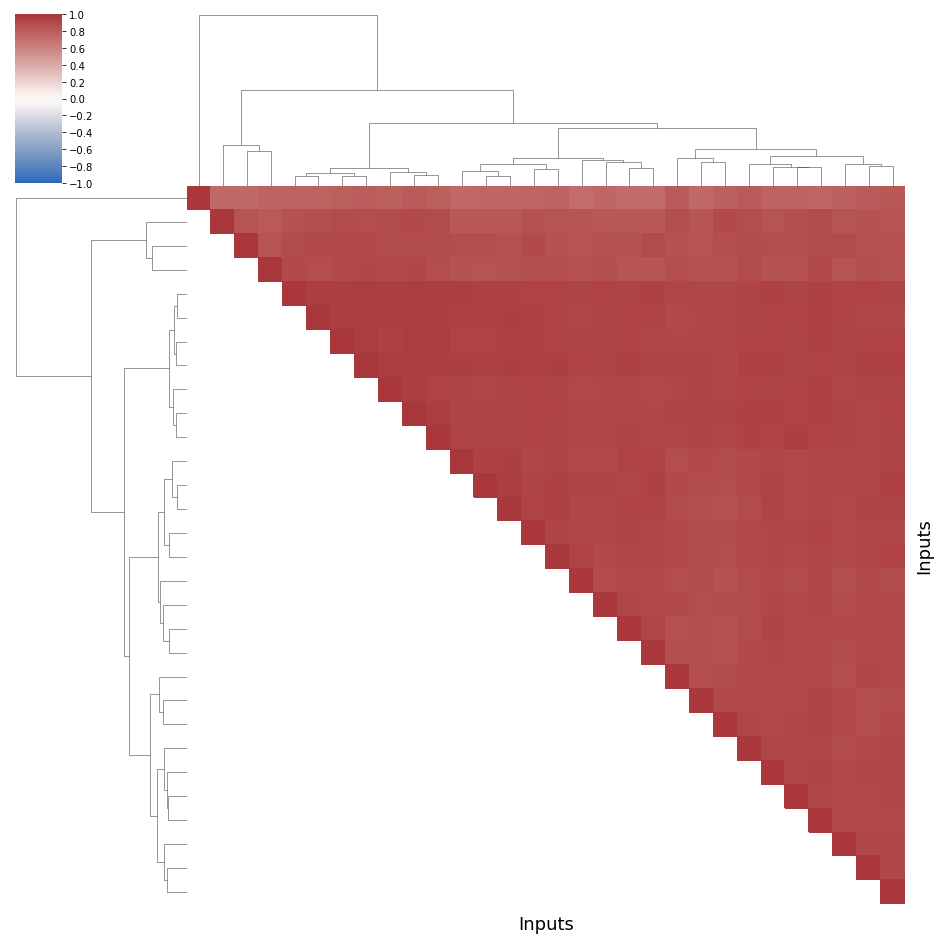

In [45]:
corr = plot_correlationmatrix_dendogram("gcc", "ctime")

In [46]:
describe(corr)

count    435.00
mean       0.91
std        0.05
min        0.72
25%        0.89
50%        0.92
75%        0.94
max        0.97
dtype: float64

These distribution of compilation times are mostly highly correlated with each other.

The minimal value, fixed at 0.72, is not even a moderate correlations, and 75% of the correlations are above the value of 0.9

We observe very low values of compile times, sometimes in miliseconds.
This can explain the poor correlogram.

Practictally, it might be caused by the sample of scripts used for this experiment.
Maybe we have to consider bigger programs or software systems, compile it, and include it in the study.
Here there is only one class.

#### execution time

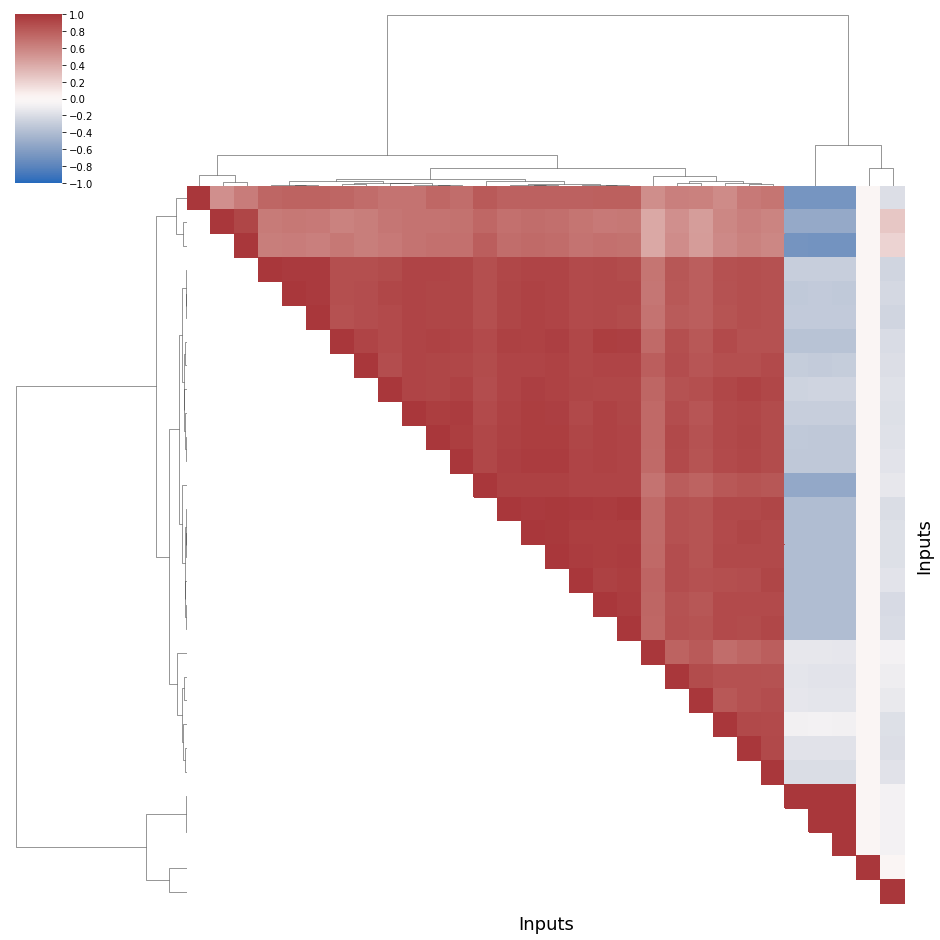

In [47]:
corr = plot_correlationmatrix_dendogram("gcc", "exec")

In [48]:
describe(corr)

count    406.00
mean       0.56
std        0.51
min       -0.69
25%        0.22
50%        0.84
75%        0.92
max        1.00
dtype: float64

These distribution of execution times are mostly correlated with each other.

But there are some negative correlations for a set of scripts. There are 2 groups of scripts, uncorrelated with each other.

#### size

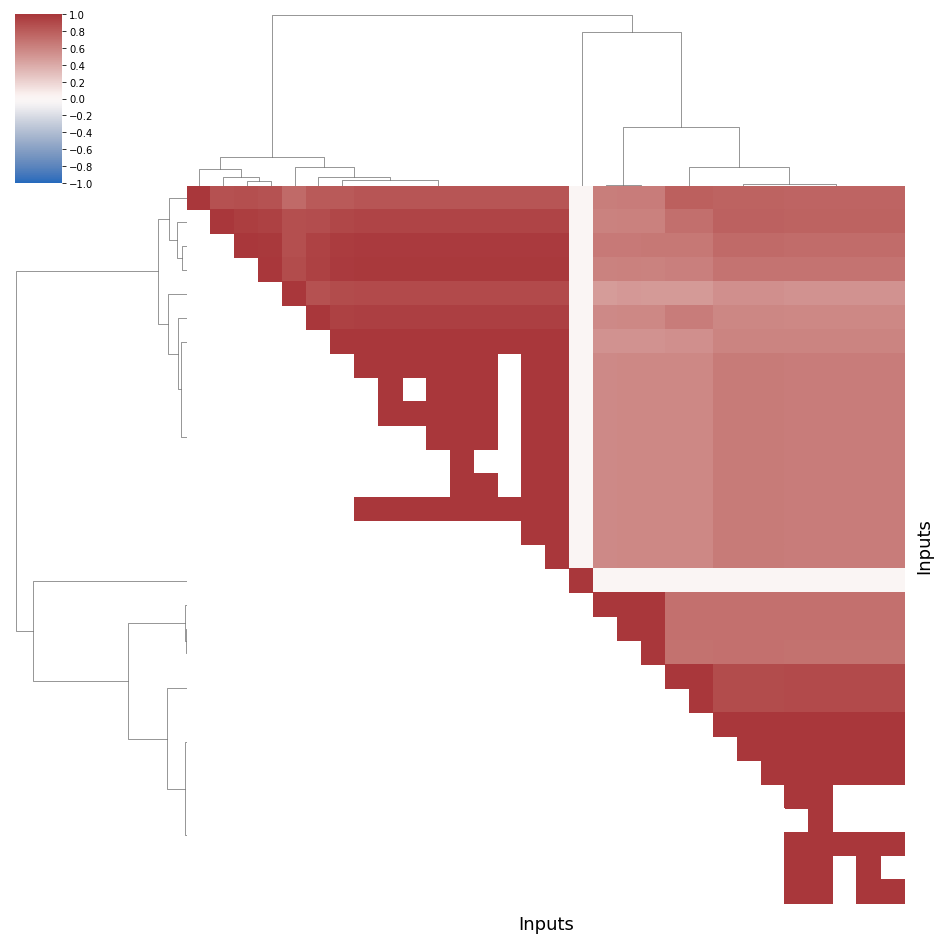

In [49]:
corr = plot_correlationmatrix_dendogram("gcc", "size")

In [50]:
describe(corr)

count    406.00
mean       0.77
std        0.17
min        0.48
25%        0.65
50%        0.71
75%        0.96
max        1.00
dtype: float64

The binary size of the compiled programs do not change at all, which is a good news.

All correlations are positive and at least moderate.

We can reuse a model from one input to another for the binary size of gcc.

### Lingeling

#### conflicts

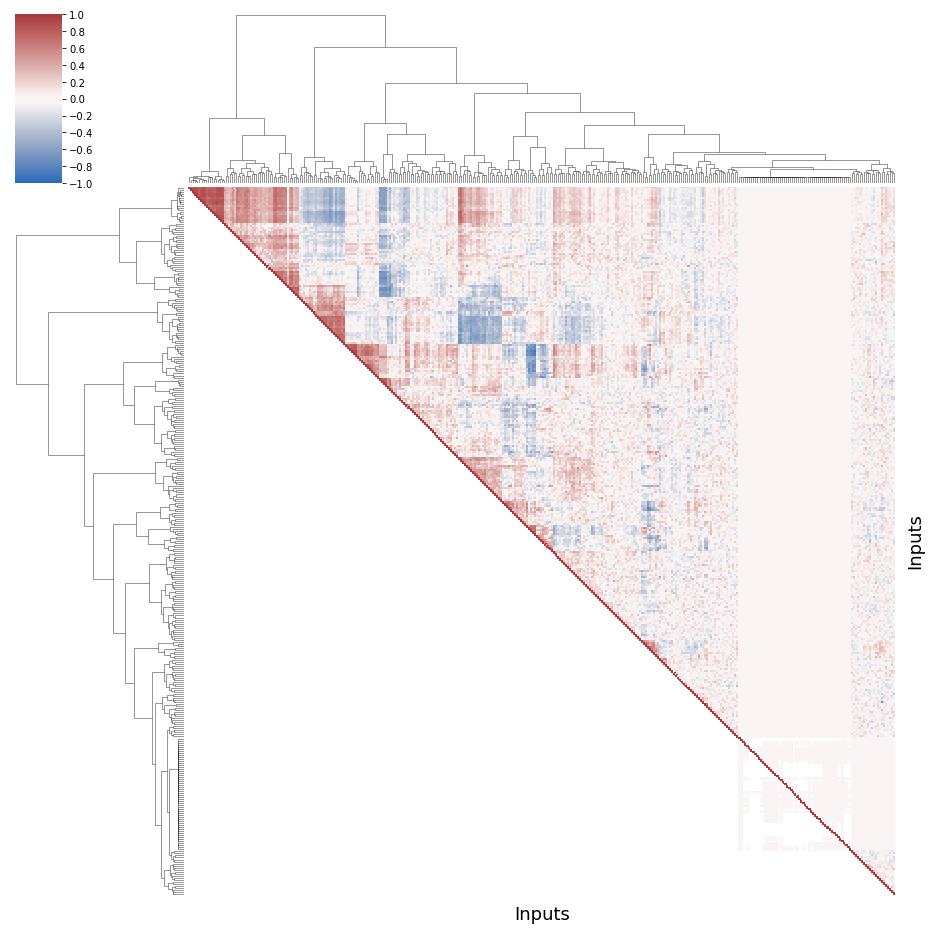

In [9]:
corr = plot_correlationmatrix_dendogram("lingeling", "conflicts")

In [10]:
describe(corr)

count    43365.00
mean         0.02
std          0.20
min         -0.90
25%         -0.09
50%          0.02
75%          0.12
max          0.92
dtype: float64

For lingeling and the number of conflicts in total, we got lots of tiny classes of SAT formulae.

These are gloablly uncorrelated (very low, low, or moderate) with each other, apart from one or groups (e.g. top-left of the chart), with a few cases of very high negative correlations.

Training a performance model on this performance property and for this software system would be a nightmare, we cannot reuse anything.

#### conflicts per second

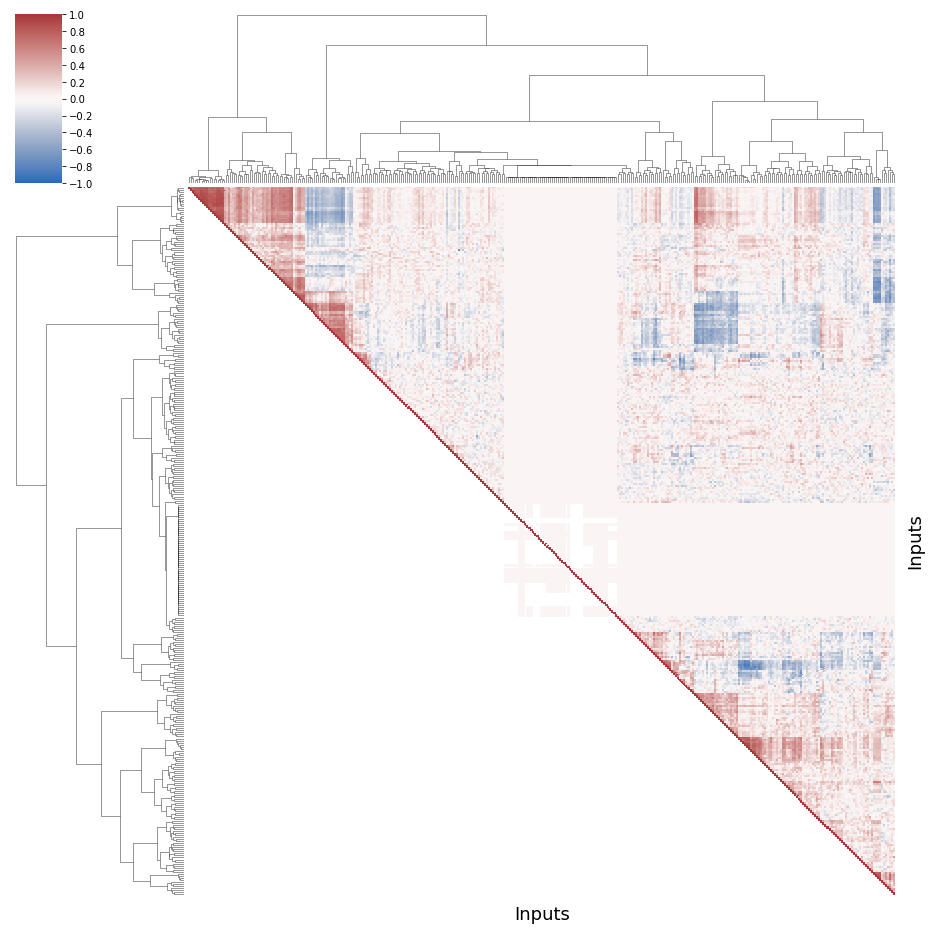

In [11]:
corr = plot_correlationmatrix_dendogram("lingeling", "cps")

In [12]:
describe(corr)

count    43365.00
mean         0.02
std          0.20
min         -0.89
25%         -0.09
50%          0.02
75%          0.12
max          0.93
dtype: float64

For lingeling and the number of conflicts per second in total, we can draw the same conclusions as conflicts:

These are gloablly uncorrelated (very low, low, or moderate) with each other, apart from one or groups (e.g. top-left of the chart), with a few cases of very high negative correlations.

Training a performance model on this performance property and for this software system would be a nightmare, we cannot reuse anything.

There might be some tiny differences explaining the different clusters between conflicts and cps.

#### reductions

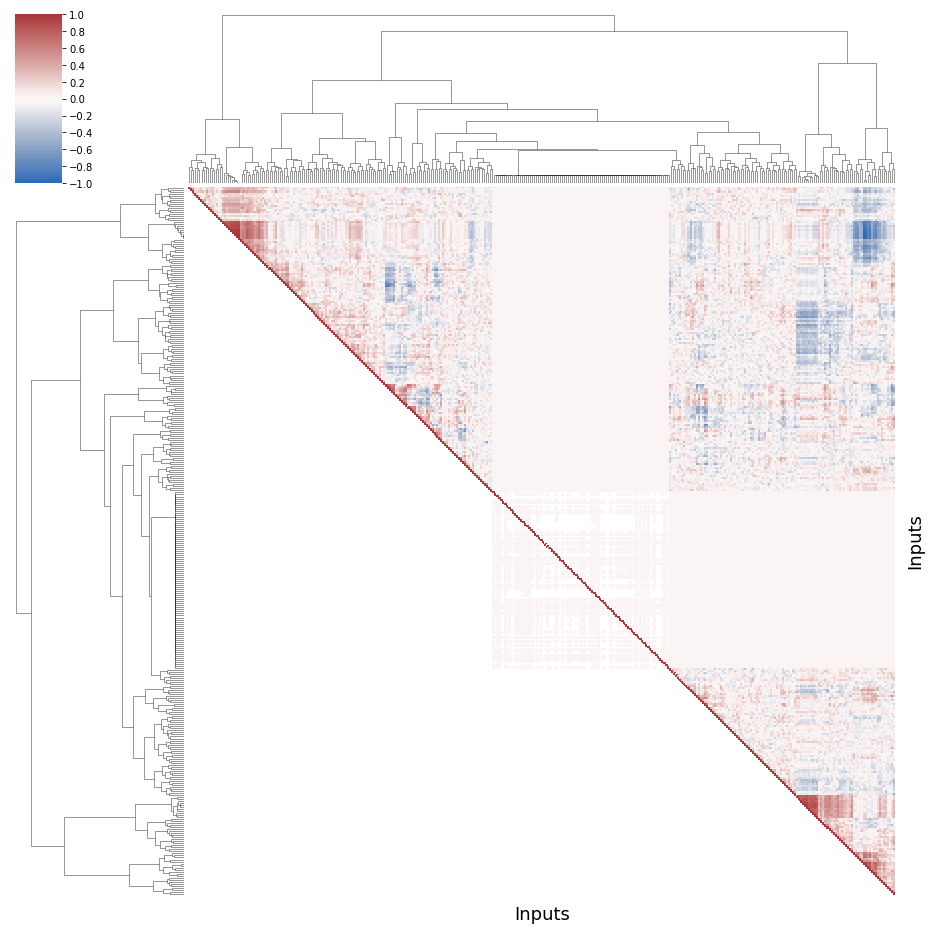

In [13]:
corr = plot_correlationmatrix_dendogram("lingeling", "reductions")

In [14]:
describe(corr)

count    34453.00
mean         0.01
std          0.18
min         -0.99
25%         -0.10
50%          0.01
75%          0.11
max          1.00
dtype: float64

For many SAT formulae, lingeling does not find any reduction. In this figure, this is represented by the white group in the middle of the correlogram.

Apart from it, it is a bit like conflicts; a lot of uncorrelated values, a few "more than moderate" correlations, either positive or negative.

### NodeJS

#### number of operations per second

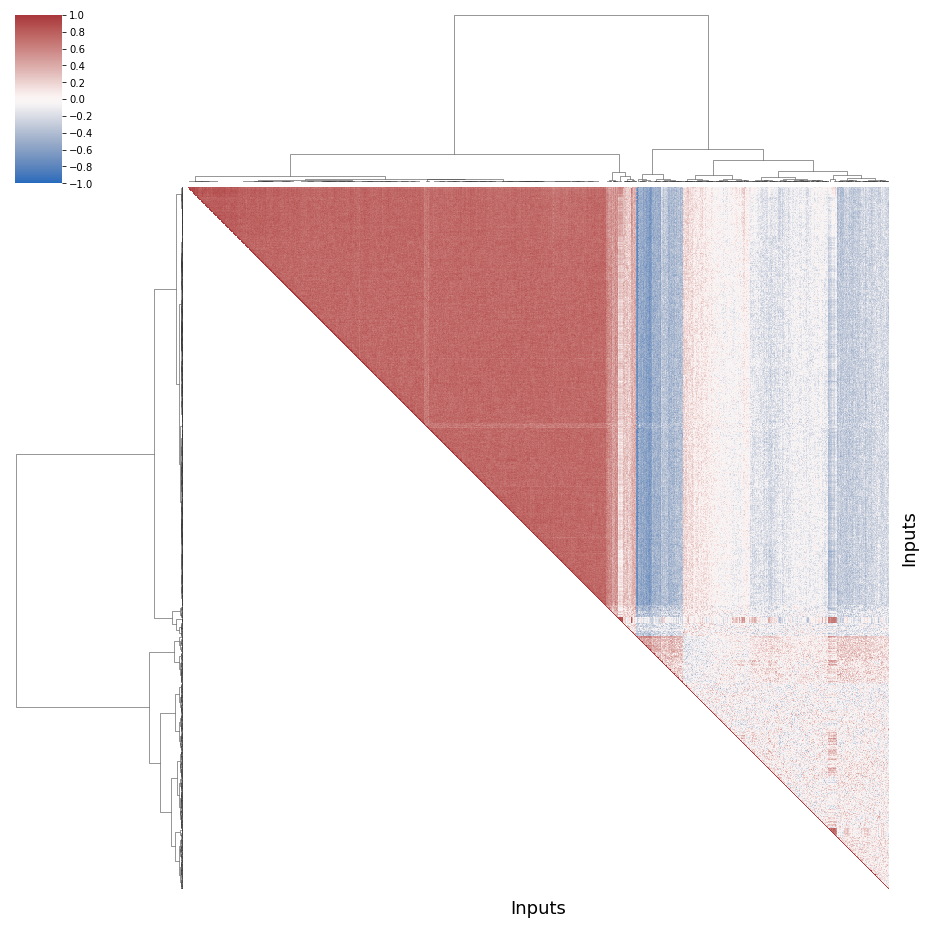

In [15]:
corr = plot_correlationmatrix_dendogram("nodejs", "ops")

In [16]:
describe(corr)

count    1863415.00
mean           0.22
std            0.44
min           -0.87
25%           -0.14
50%            0.09
75%            0.72
max            0.95
dtype: float64

NodeJs is an interesting case, where we can observe one big highly-correlated group of inputs, and after that lots of uncorrelated scripts in terms of operations per second.

The first group has in general low or moderate correlations, all positive.

There are mostly high negative correlations between this big group and the rest of the scripts.

### Poppler

#### size

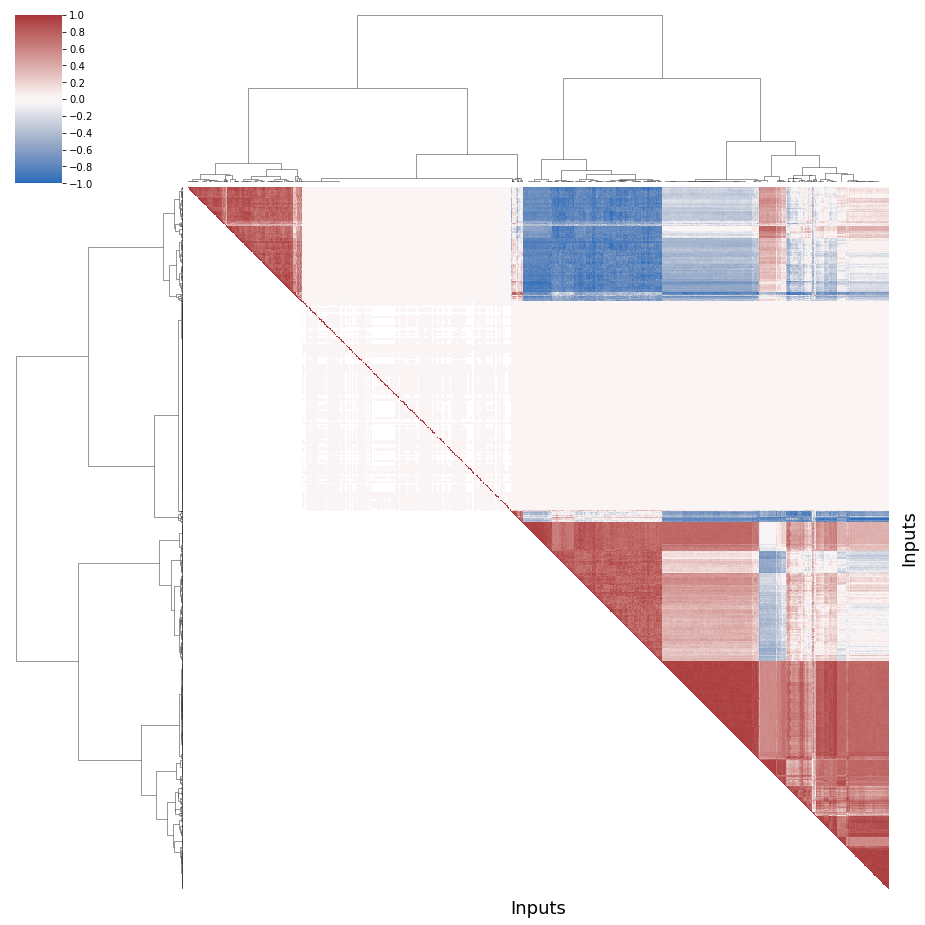

In [17]:
corr = plot_correlationmatrix_dendogram("poppler", "size")

In [18]:
describe(corr)

count    540280.00
mean          0.17
std           0.57
min          -1.00
25%          -0.29
50%           0.25
75%           0.72
max           1.00
dtype: float64

Again, and like for lingeling, we cannot avoid to have few input pdfs for which there is no image in it.
 
Their size is 0, and to show their presence, we color that in white.
 
Apart from these outliers, there are different groups of pdfs, that are mostly highly and positively correlated between each other (i.e. high intra correlations) and highly but negatively correlated to the other groups.
 
We highlight few profiles of pdf when extracting their images. 

#### time

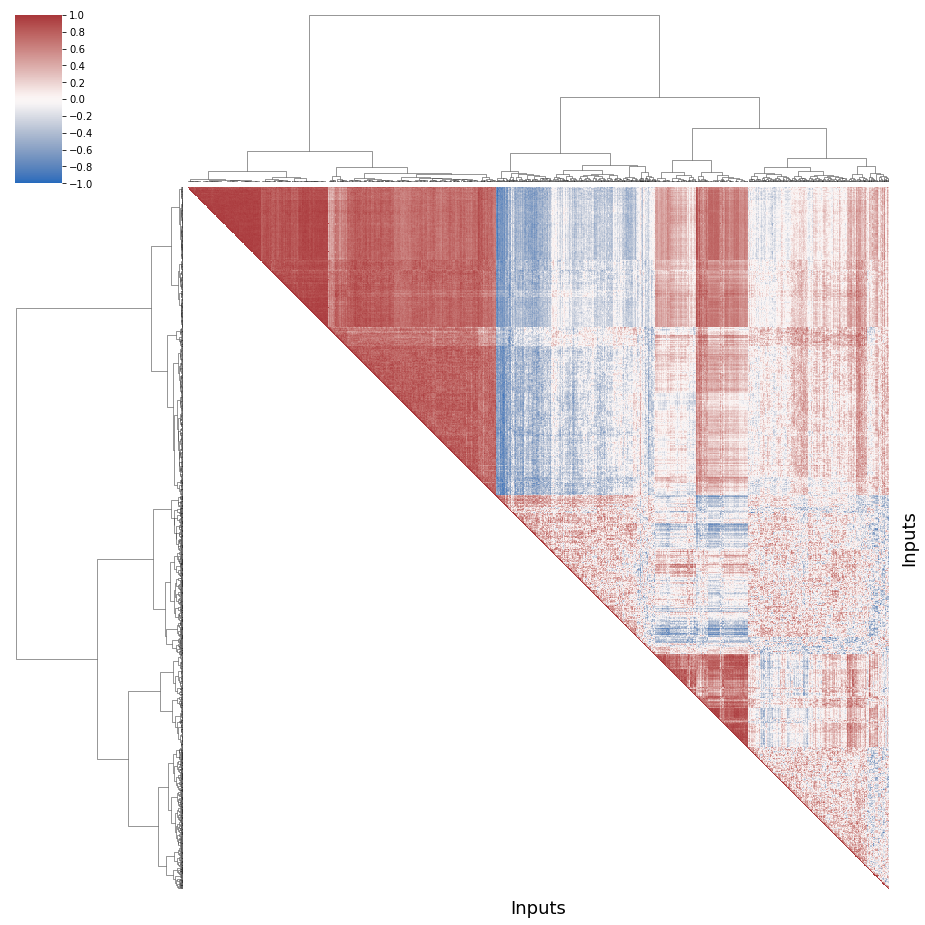

In [19]:
corr = plot_correlationmatrix_dendogram("poppler", "time")

In [20]:
describe(corr)

count    1094460.00
mean           0.19
std            0.41
min           -0.94
25%           -0.11
50%            0.15
75%            0.52
max            1.00
dtype: float64

The example of the paper.

The content of input pdfs fed to poppler may vary e.g. the pdf can be a 2-page report with a simple figure or a 300-page picture book. 
Depending on this content, extracting the images embedded in those files can be quick or slow. 
Moreover, a user can adapt different configurations for the report and not for the book (or inversely), leading to different rankings in terms of extraction time. 

In this correlaogram, we depict the Spearman rank-order correlations, in terms of extraction time, between pairs of input pdfs fed to poppler. 
We also perform hierarchical clustering on poppler data to gather inputs having similar times distributions and visually group correlated pdfs together.
Each square$_{(i,j)}$ represents the Spearman correlation between the time needed to extract the images of pdfs $i$ and $j$. The color of this square respects the top-left scale: high positive correlations are red; low in white; negative in blue. Because we cannot describe each correlation individually, we added a table describing their distribution. The diagonals are excluded.
Results suggest a positive correlation (see dark red cells), though there are pairs of inputs with lower (see white cells) and even negative (see dark blue cells) correlations. 
More than a quarter of the correlations between input pdfs are positive and at least moderate (third quartile Q3 greater than \num{0.52}).

On the top-left part of the correlogram (see triangle 1 in the article), we even observe a first group of input pdfs that are highly correlated (positively, strong or very strong) with each others. 
In this first group, the input pdfs have similar time rankings; their performance react the same way to the same configurations. 

However, this group of pdfs is uncorrelated (very low, low) or negatively correlated (moderate, strong and very strong) with the second group of pdfs (see the triangle 2, in the middle). 
In this case, a performance model trained on a pdf chosen in the first group should not be reused directly on a pdf of the second group. 

### SQLite

#### q1

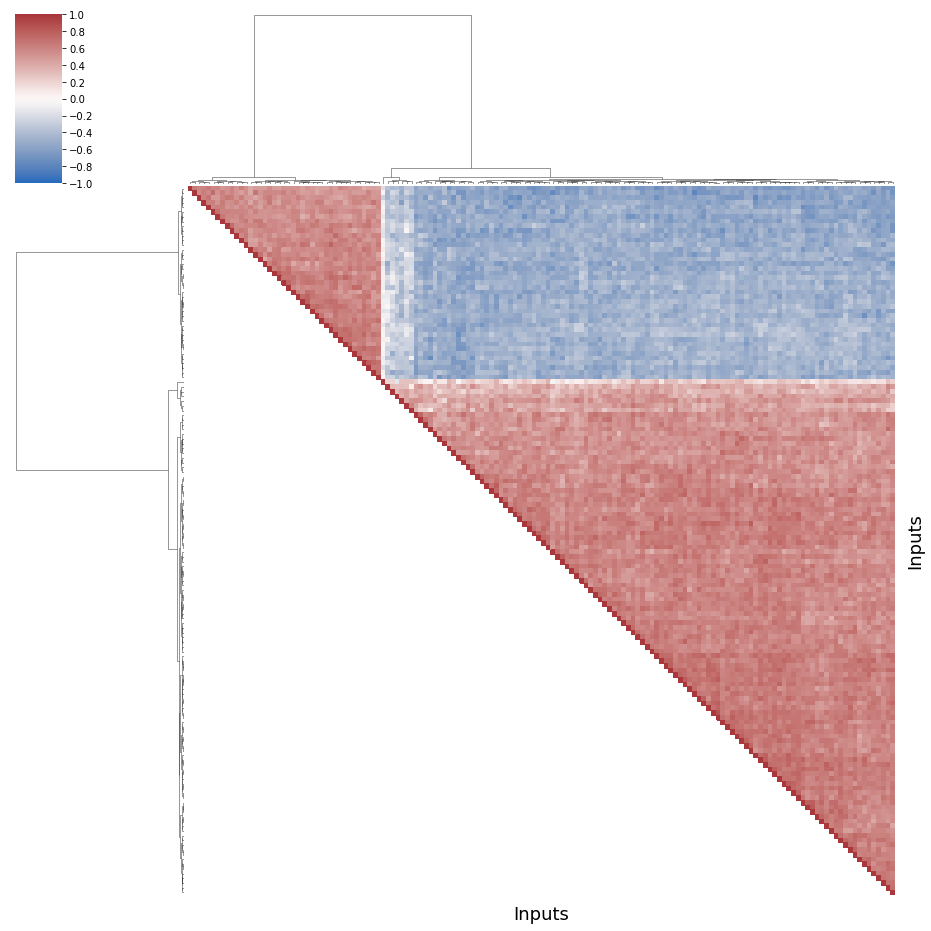

In [55]:
corr = plot_correlationmatrix_dendogram("sqlite", "q1")

In [56]:
describe(corr)

count    11175.00
mean         0.15
std          0.52
min         -0.78
25%         -0.46
50%          0.48
75%          0.60
max          0.87
dtype: float64

#### q2

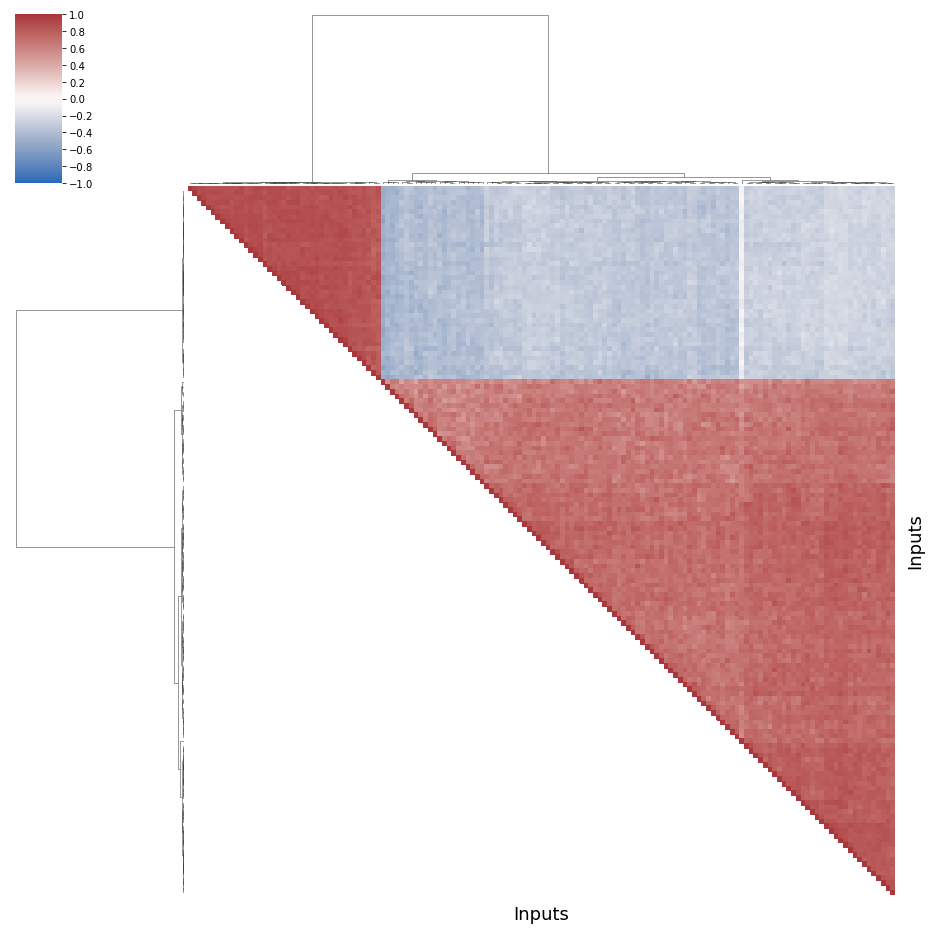

In [57]:
corr = plot_correlationmatrix_dendogram("sqlite", "q2")

In [58]:
describe(corr)

count    11175.00
mean         0.32
std          0.52
min         -0.58
25%         -0.29
50%          0.66
75%          0.75
max          0.94
dtype: float64

#### q3

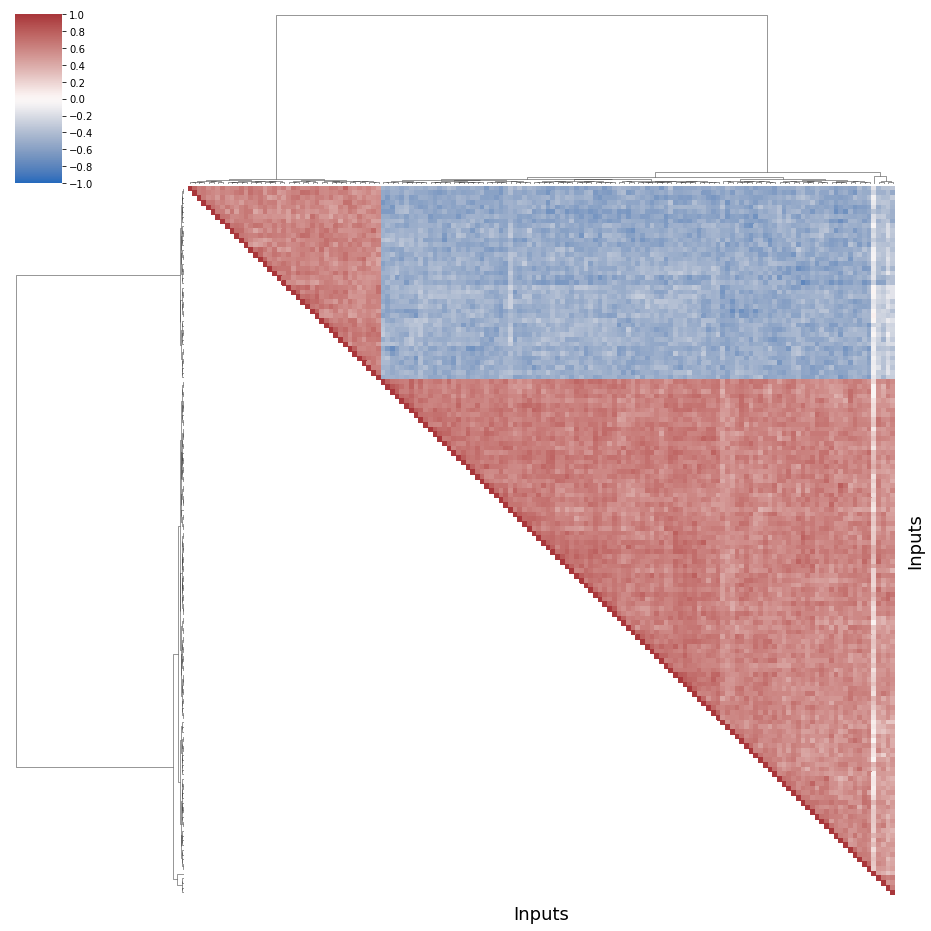

In [59]:
corr = plot_correlationmatrix_dendogram("sqlite", "q3")

In [60]:
describe(corr)

count    11175.00
mean         0.16
std          0.54
min         -0.78
25%         -0.47
50%          0.52
75%          0.62
max          0.84
dtype: float64

#### q4

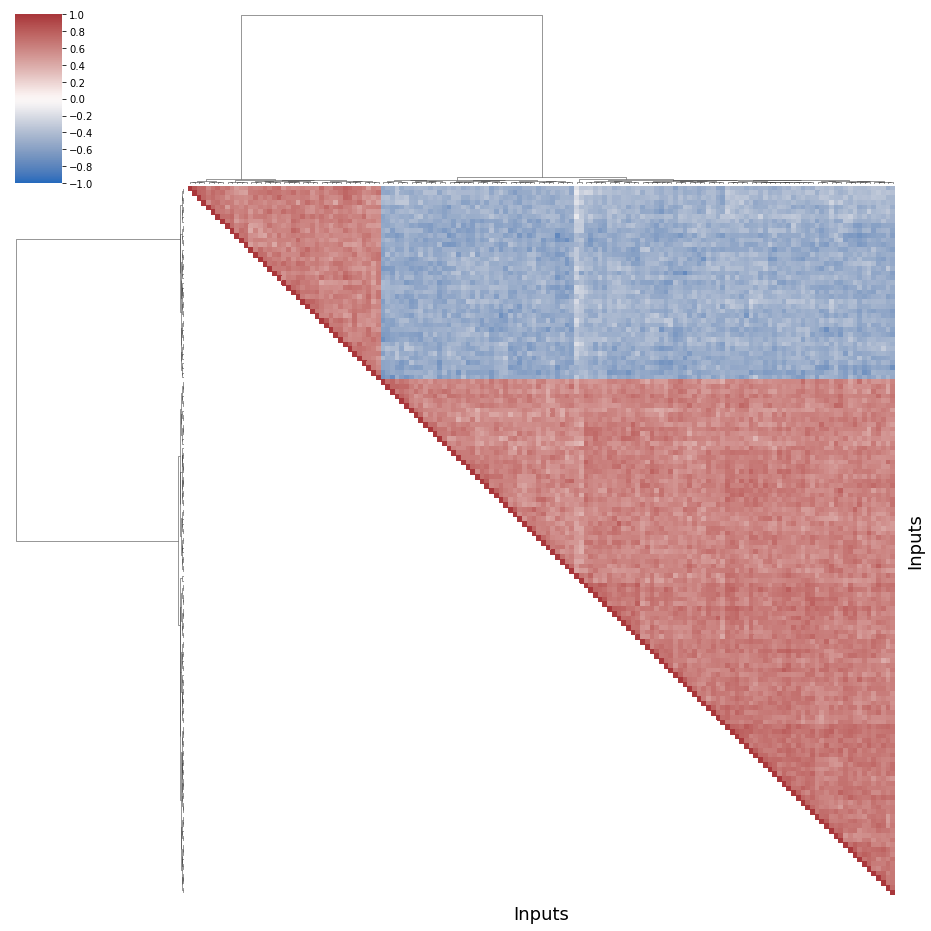

In [61]:
corr = plot_correlationmatrix_dendogram("sqlite", "q4")

In [62]:
describe(corr)

count    11175.00
mean         0.17
std          0.54
min         -0.77
25%         -0.47
50%          0.54
75%          0.62
max          0.84
dtype: float64

#### q5

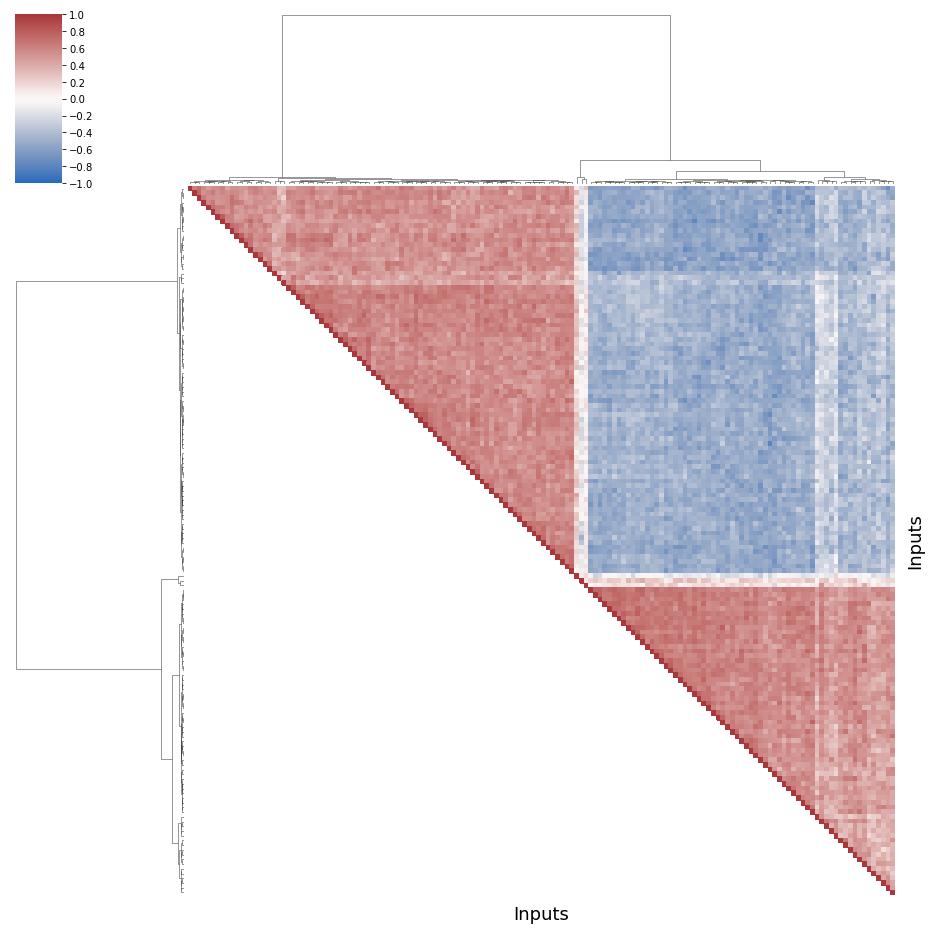

In [63]:
corr = plot_correlationmatrix_dendogram("sqlite", "q5")

In [64]:
describe(corr)

count    11175.00
mean         0.05
std          0.51
min         -0.80
25%         -0.47
50%          0.11
75%          0.55
max          0.81
dtype: float64

#### q6

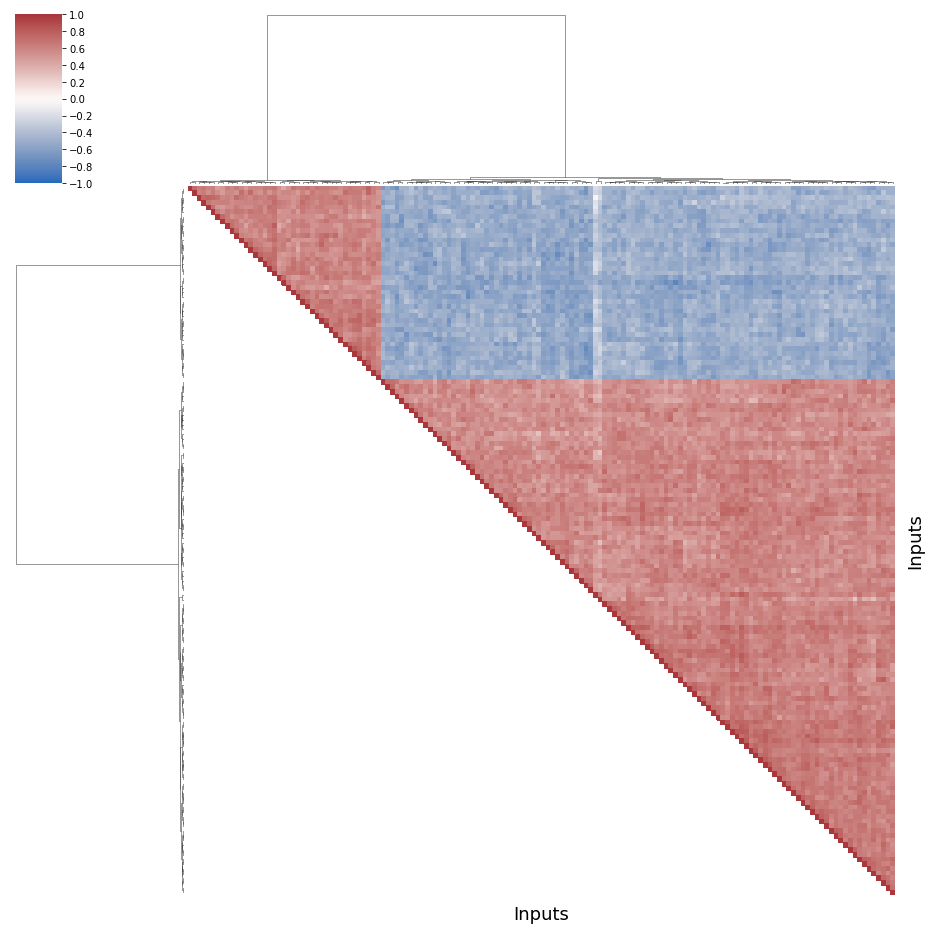

In [65]:
corr = plot_correlationmatrix_dendogram("sqlite", "q6")

In [66]:
describe(corr)

count    11175.00
mean         0.15
std          0.54
min         -0.80
25%         -0.48
50%          0.52
75%          0.61
max          0.86
dtype: float64

#### q7

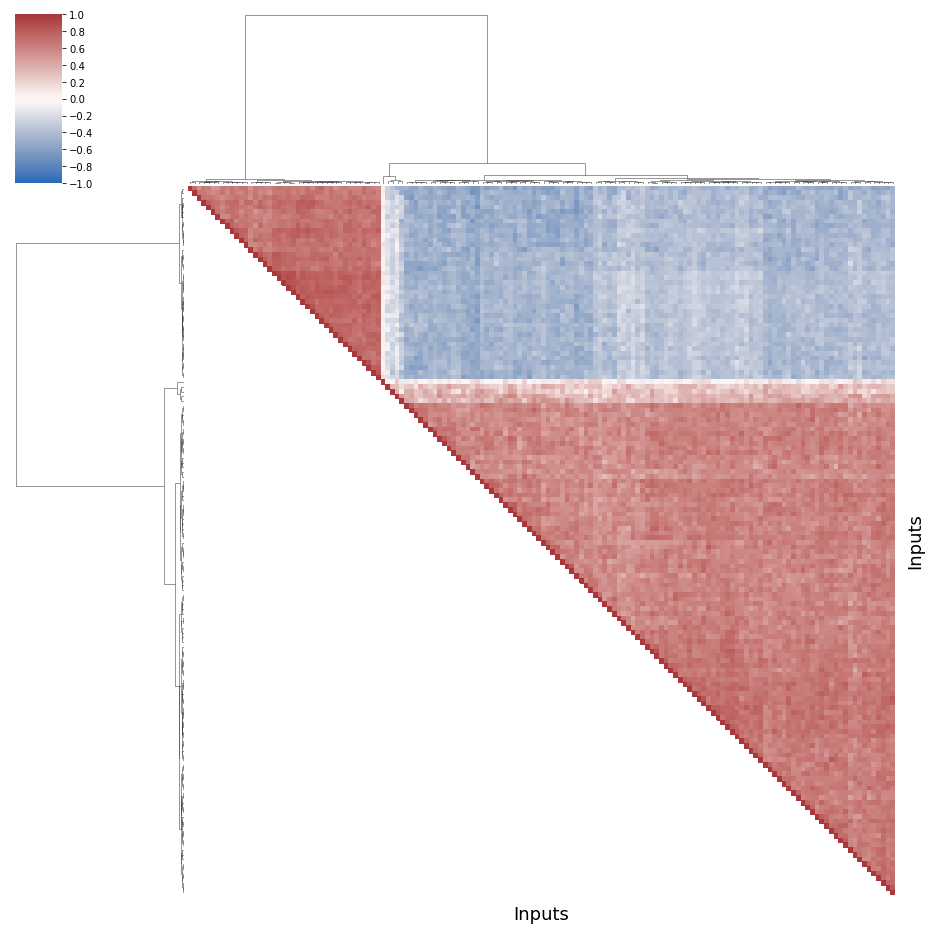

In [67]:
corr = plot_correlationmatrix_dendogram("sqlite", "q7")

In [68]:
describe(corr)

count    11175.00
mean         0.20
std          0.50
min         -0.71
25%         -0.38
50%          0.52
75%          0.64
max          0.92
dtype: float64

#### q8

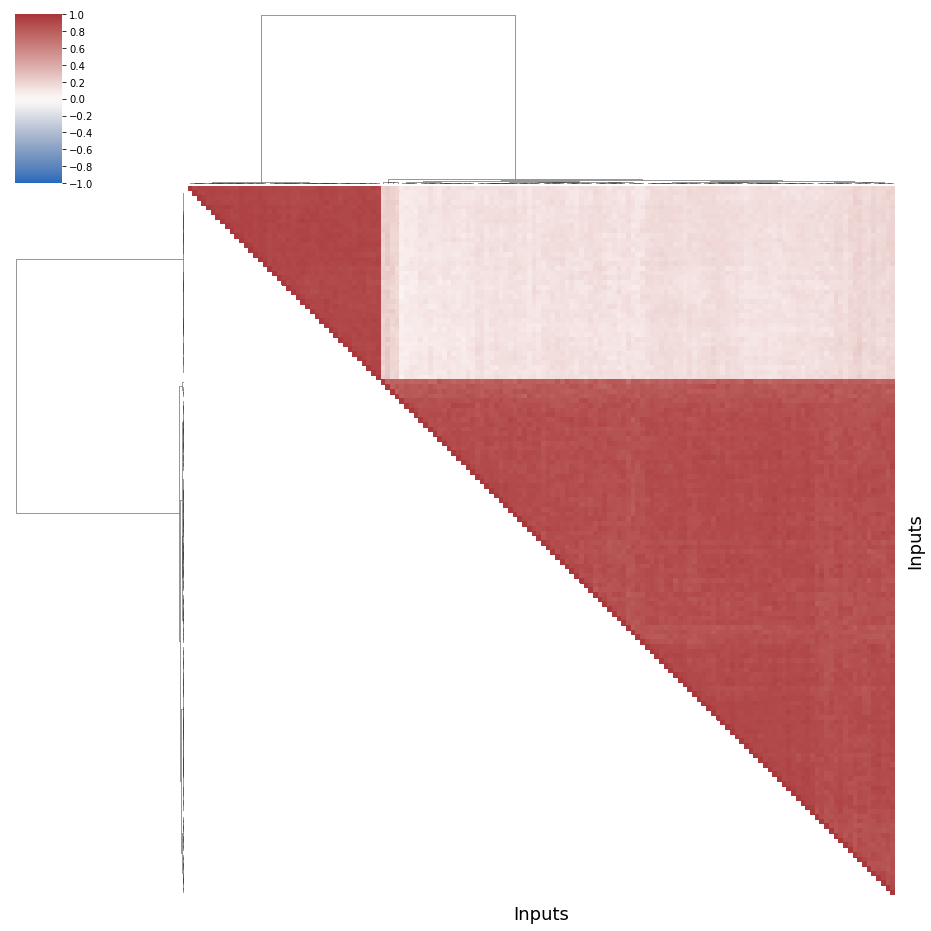

In [69]:
corr = plot_correlationmatrix_dendogram("sqlite", "q8")

In [70]:
describe(corr)

count    11175.00
mean         0.59
std          0.37
min          0.03
25%          0.15
50%          0.86
75%          0.90
max          0.96
dtype: float64

#### q9

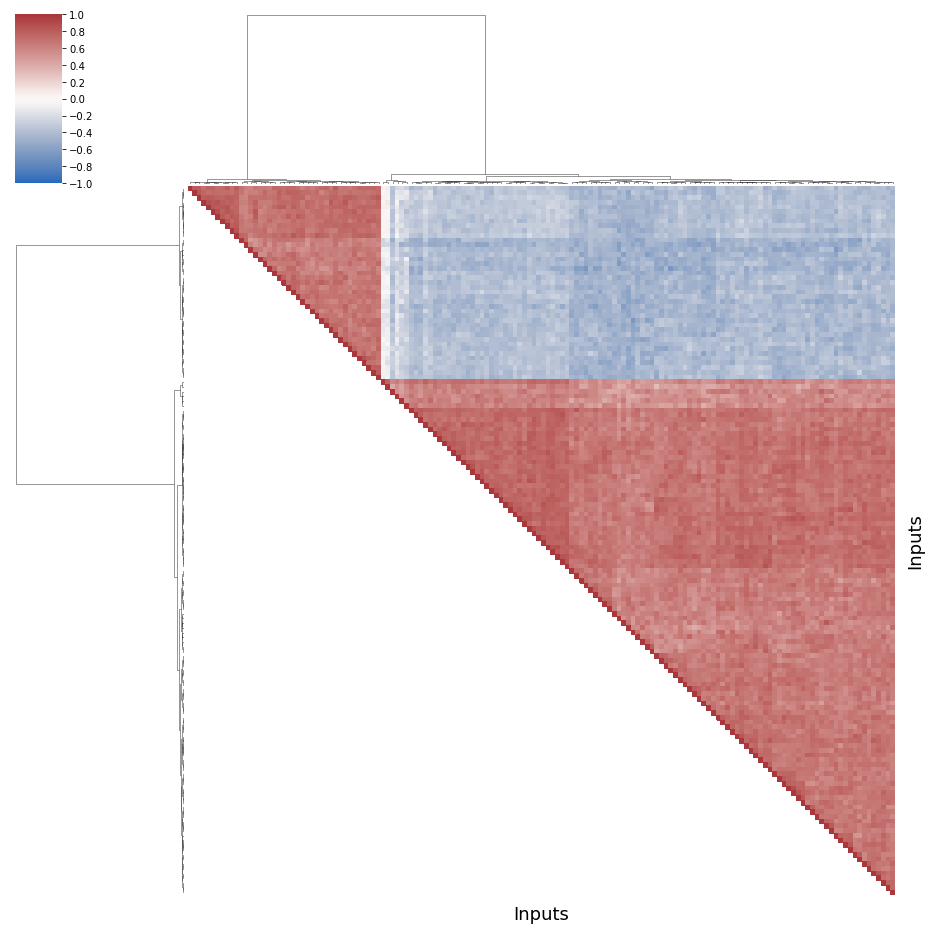

In [71]:
corr = plot_correlationmatrix_dendogram("sqlite", "q9")

In [72]:
describe(corr)

count    11175.00
mean         0.24
std          0.53
min         -0.67
25%         -0.38
50%          0.60
75%          0.69
max          0.89
dtype: float64

#### q10

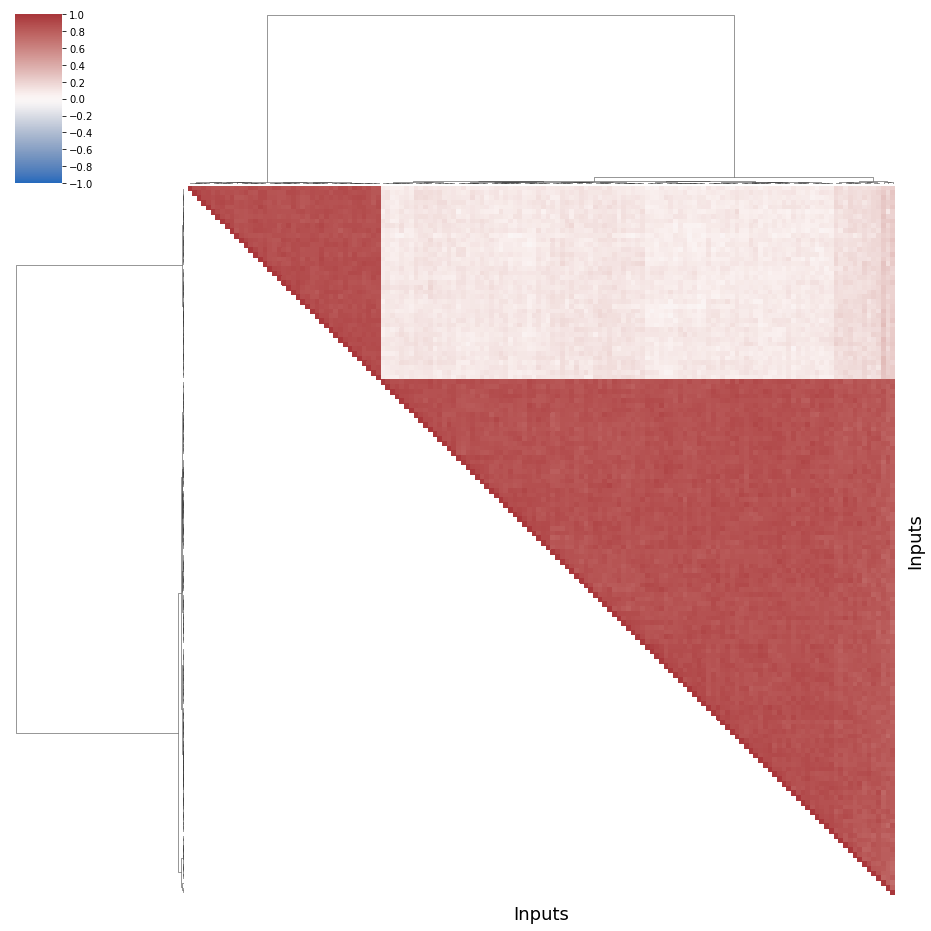

In [73]:
corr = plot_correlationmatrix_dendogram("sqlite", "q10")

In [74]:
describe(corr)

count    11175.00
mean         0.56
std          0.37
min          0.00
25%          0.11
50%          0.84
75%          0.87
max          0.96
dtype: float64

#### q11

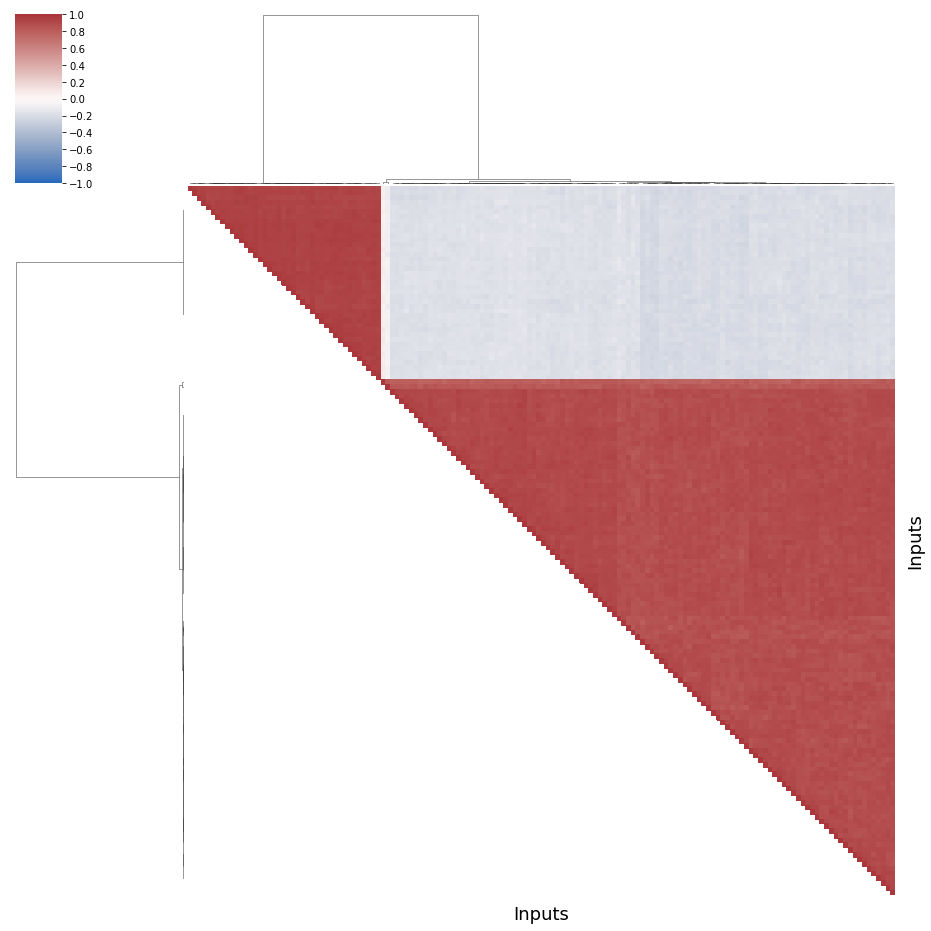

In [75]:
corr = plot_correlationmatrix_dendogram("sqlite", "q11")

In [76]:
describe(corr)

count    11175.00
mean         0.47
std          0.53
min         -0.25
25%         -0.18
50%          0.87
75%          0.90
max          0.97
dtype: float64

#### q12

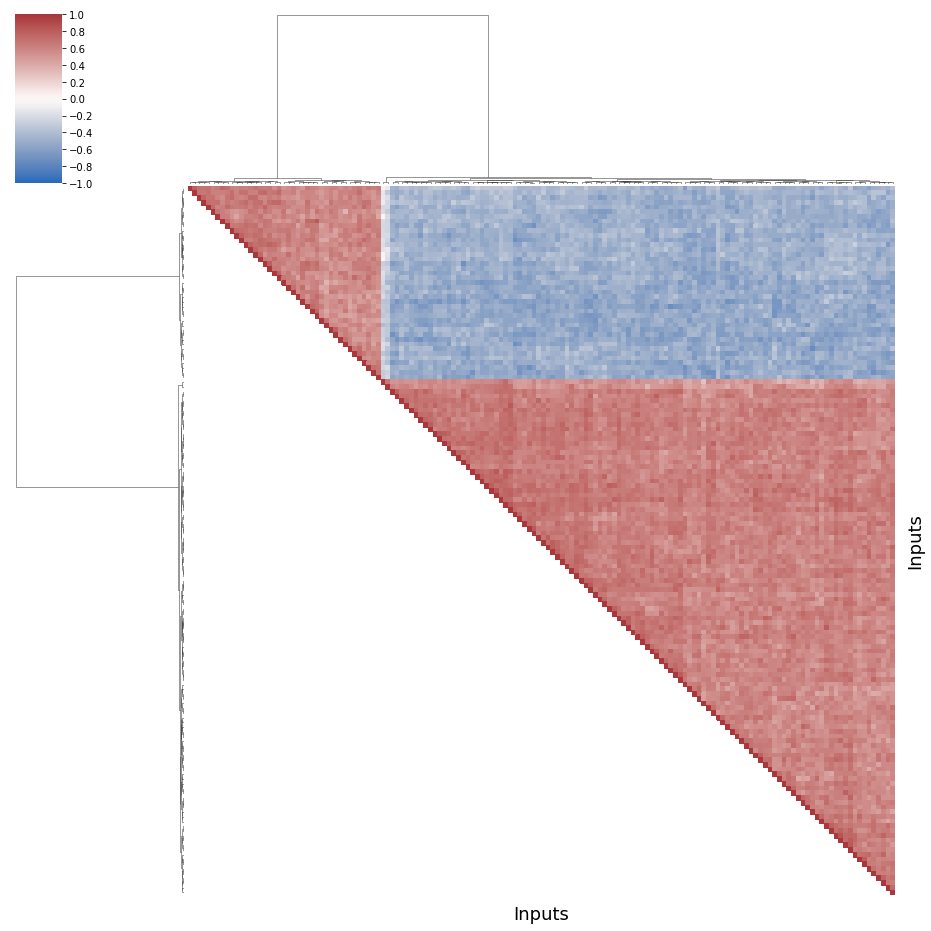

In [77]:
corr = plot_correlationmatrix_dendogram("sqlite", "q12")

In [78]:
describe(corr)

count    11175.00
mean         0.17
std          0.55
min         -0.74
25%         -0.47
50%          0.54
75%          0.63
max          0.85
dtype: float64

#### q13

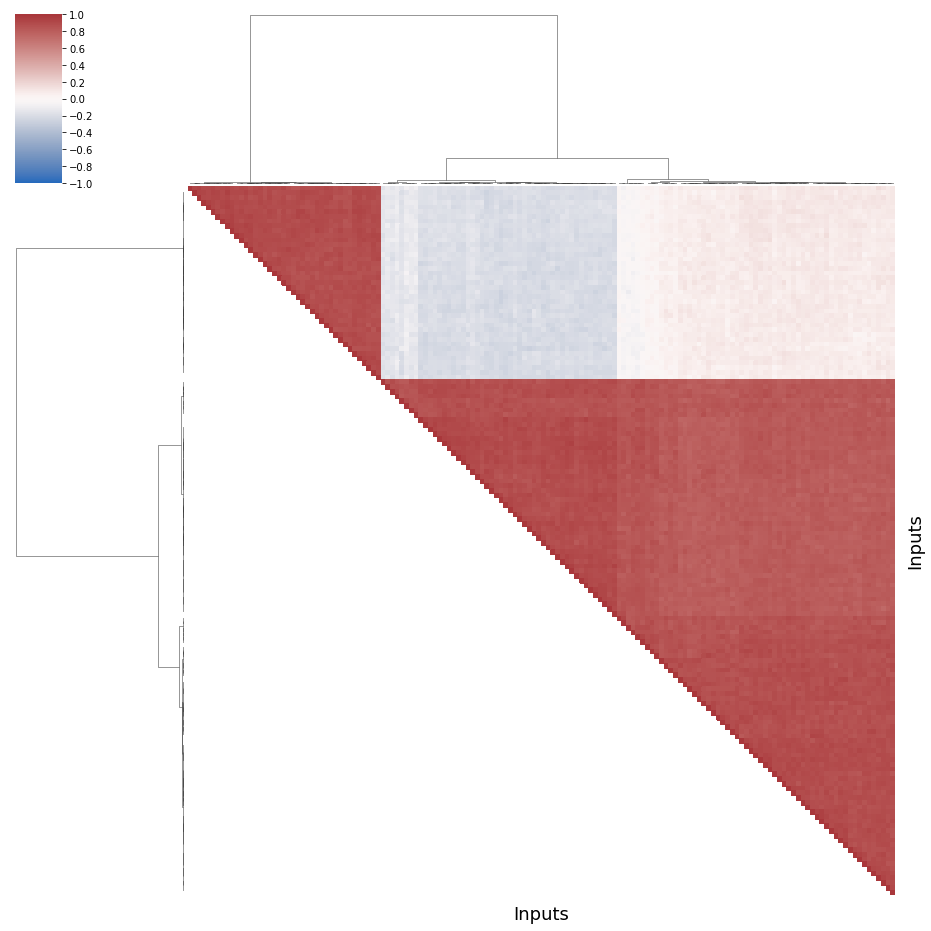

In [79]:
corr = plot_correlationmatrix_dendogram("sqlite", "q13")

In [80]:
describe(corr)

count    11175.00
mean         0.49
std          0.45
min         -0.27
25%          0.06
50%          0.81
75%          0.87
max          0.95
dtype: float64

 #### q14

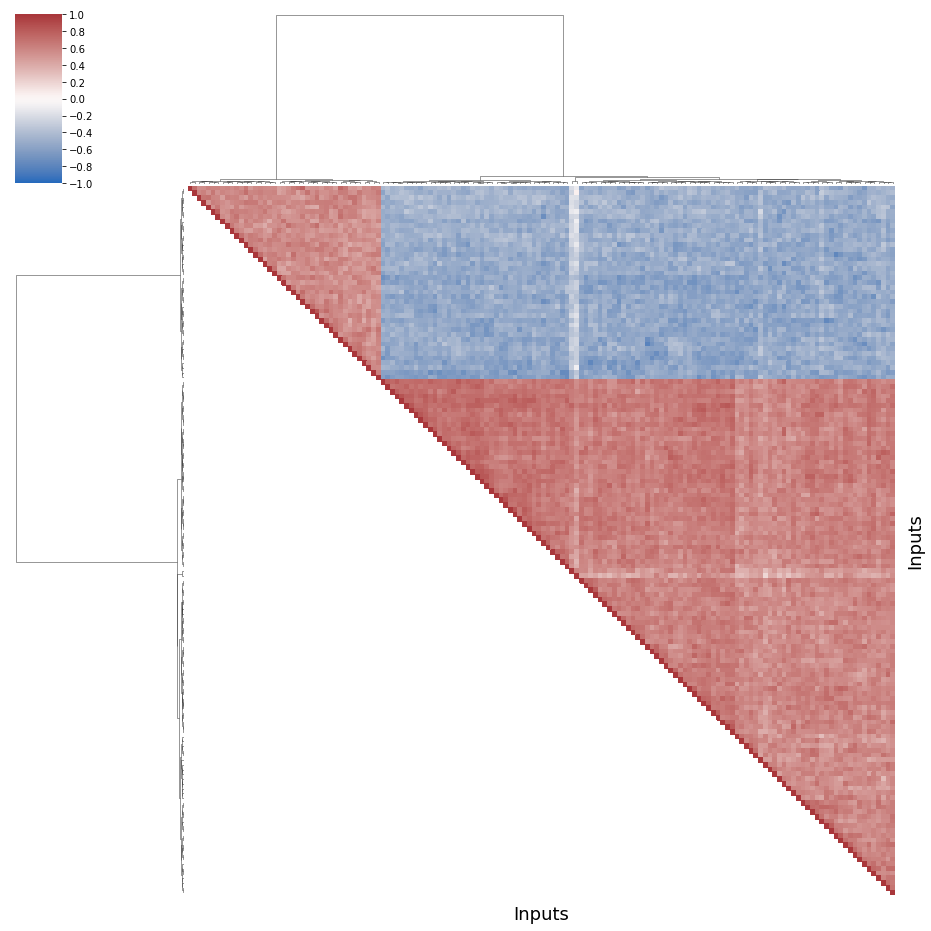

In [81]:
corr = plot_correlationmatrix_dendogram("sqlite", "q14")

In [82]:
describe(corr)

count    11175.00
mean         0.16
std          0.56
min         -0.81
25%         -0.50
50%          0.53
75%          0.63
max          0.87
dtype: float64

#### q15

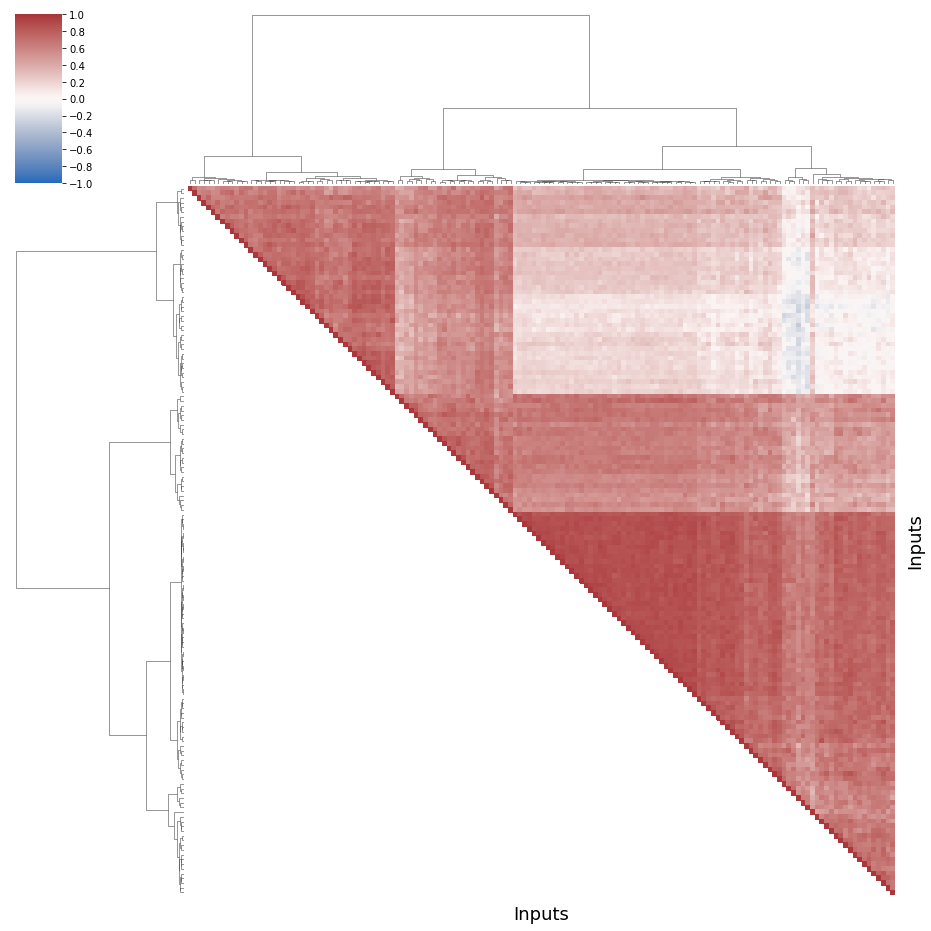

In [83]:
corr = plot_correlationmatrix_dendogram("sqlite", "q15")

In [84]:
describe(corr)

count    11175.00
mean         0.51
std          0.26
min         -0.30
25%          0.29
50%          0.59
75%          0.72
max          0.94
dtype: float64

Overall, two groups of databases appears; these two groups are highly-correlated (i.e. inside the groups) but uncorrelated or negatively correlated with each others

### xz

#### size

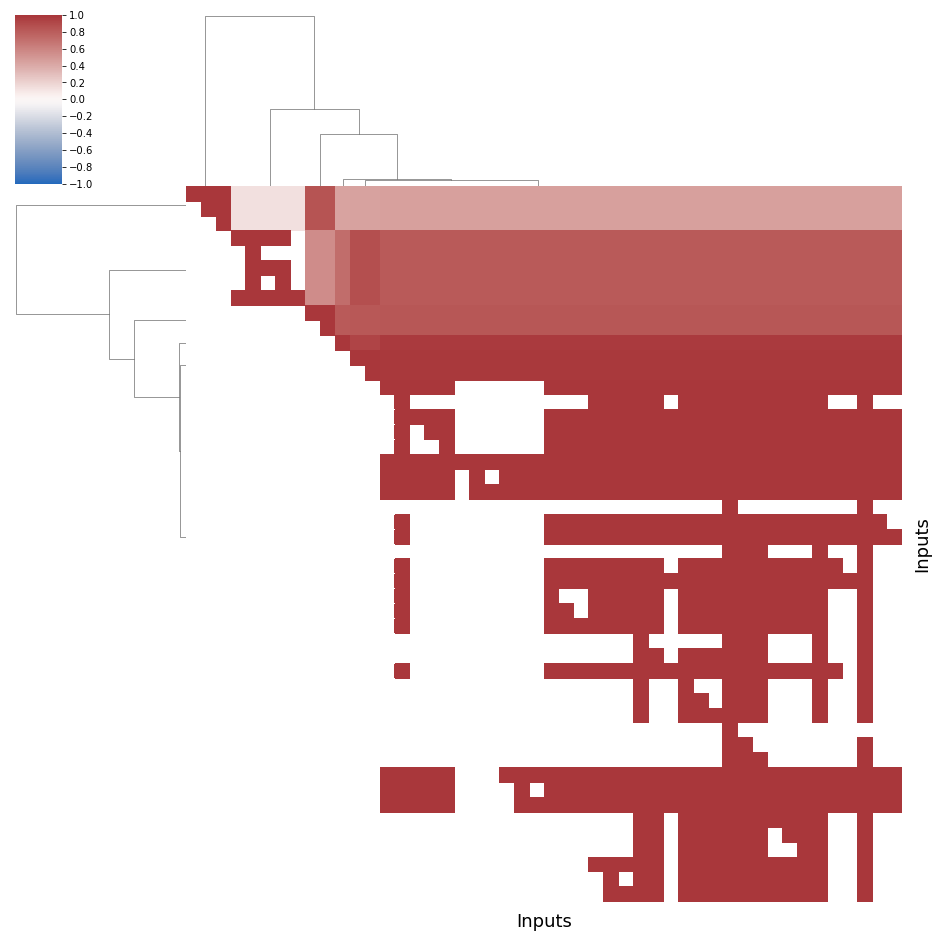

In [21]:
corr = plot_correlationmatrix_dendogram("xz", "size")

In [22]:
describe(corr)

count    1128.00
mean        0.89
std         0.19
min         0.14
25%         0.82
50%         1.00
75%         1.00
max         1.00
dtype: float64

As for gcc, xz is not so concerned by input sensitivity.

In particular, the sizes of the output file in bytes, are very highly correlated for a vast majority of inputs, with a first quartile at 0.82.

Few files are a bit different, but all correlations stay negative for this performance property!


#### time

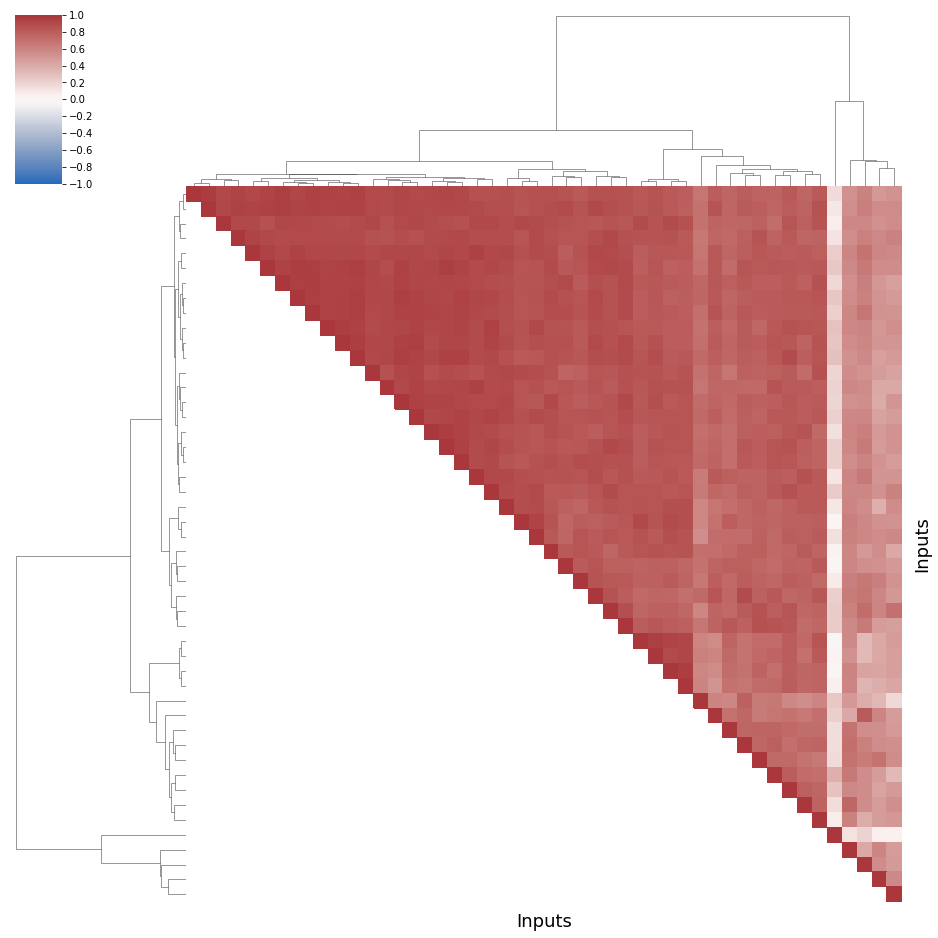

In [23]:
corr = plot_correlationmatrix_dendogram("xz", "time")

In [24]:
describe(corr)

count    1128.00
mean        0.76
std         0.18
min        -0.03
25%         0.72
50%         0.82
75%         0.88
max         0.97
dtype: float64

For time, it is less obvious.

Overall, it is quite the same, with lower correlation values.

But one input uncorrelated with all the others suggest that we could improve the dataset of input we use (the tiniest of all the experiments).

Maybe by adding big files, it would be like the other software systems.

### x264

#### bitrate

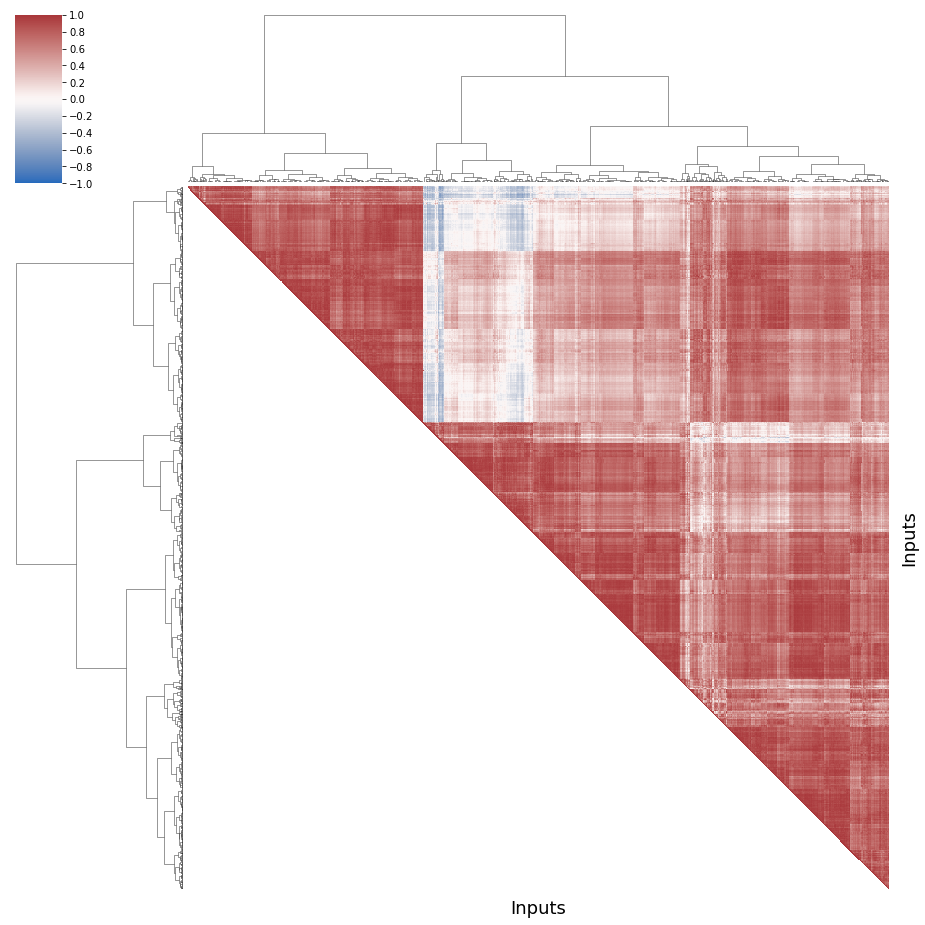

In [25]:
corr = plot_correlationmatrix_dendogram("x264", "kbs")

In [26]:
describe(corr)

count    975106.00
mean          0.57
std           0.29
min          -0.69
25%           0.39
50%           0.63
75%           0.79
max           1.00
dtype: float64

for bitrate, the input sensitivity is high with moderate correlation on average (0.57), low correlation for first quartile (0.39), and some negative correlations (up to -0.69)

On the positive side, half of the videos have strong positive correlations between their bitrates distributions (i.e. 0.63), and a quarter of the videos have very strong positive correlations (Q3 = 0.79).

There are, however, less favorable cases with lower and negative coefficients: the worst case being -0.69, between videos 9 and 503; those negative results suggest that some videos have very different performance distributions. This may lead to negative transfer.
    
We can observe four groups of video, similar to what has been observed for poppler and extraction time. We detail that in results/x264_groups


#### frame encoded per second

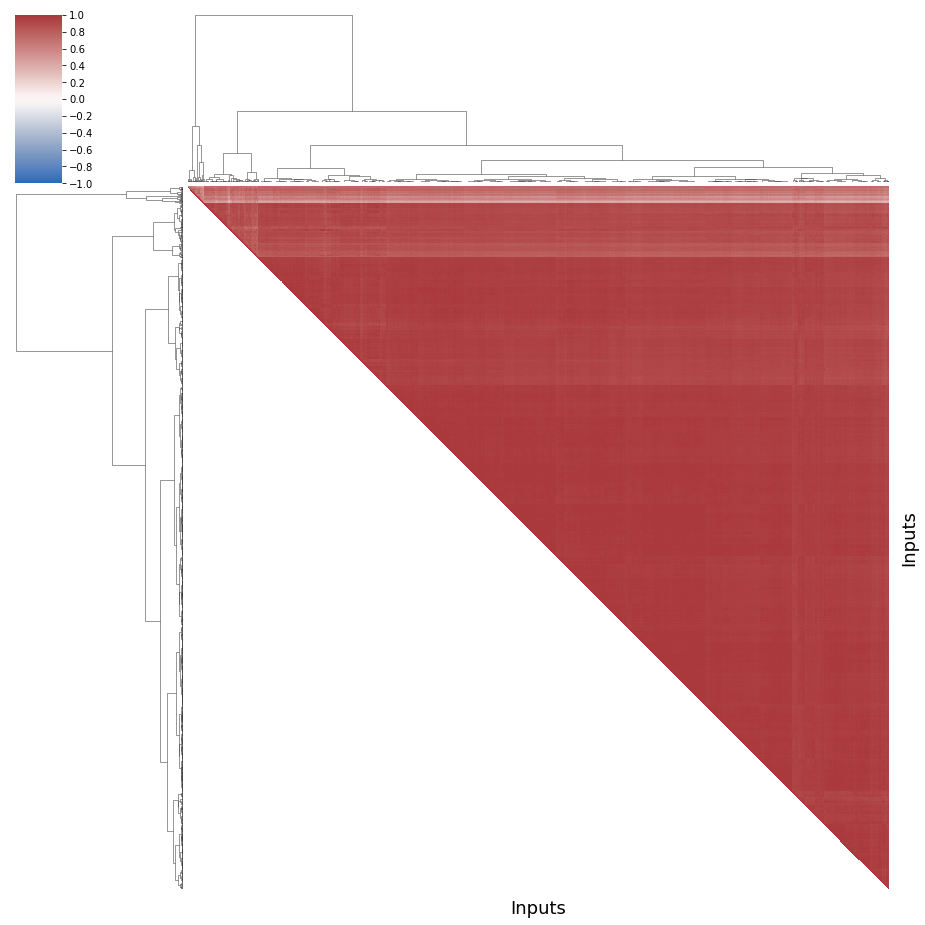

In [27]:
corr = plot_correlationmatrix_dendogram("x264", "fps")

In [28]:
describe(corr)

count    975106.00
mean          0.93
std           0.08
min           0.01
25%           0.93
50%           0.96
75%           0.97
max           1.00
dtype: float64

for fps, we observe again very strong correlations (0.93 on average and for first quartile). Even extreme cases exhibit moderate correlations 0.50: we can conclude that the input sensitivity is low

#### CPU usage

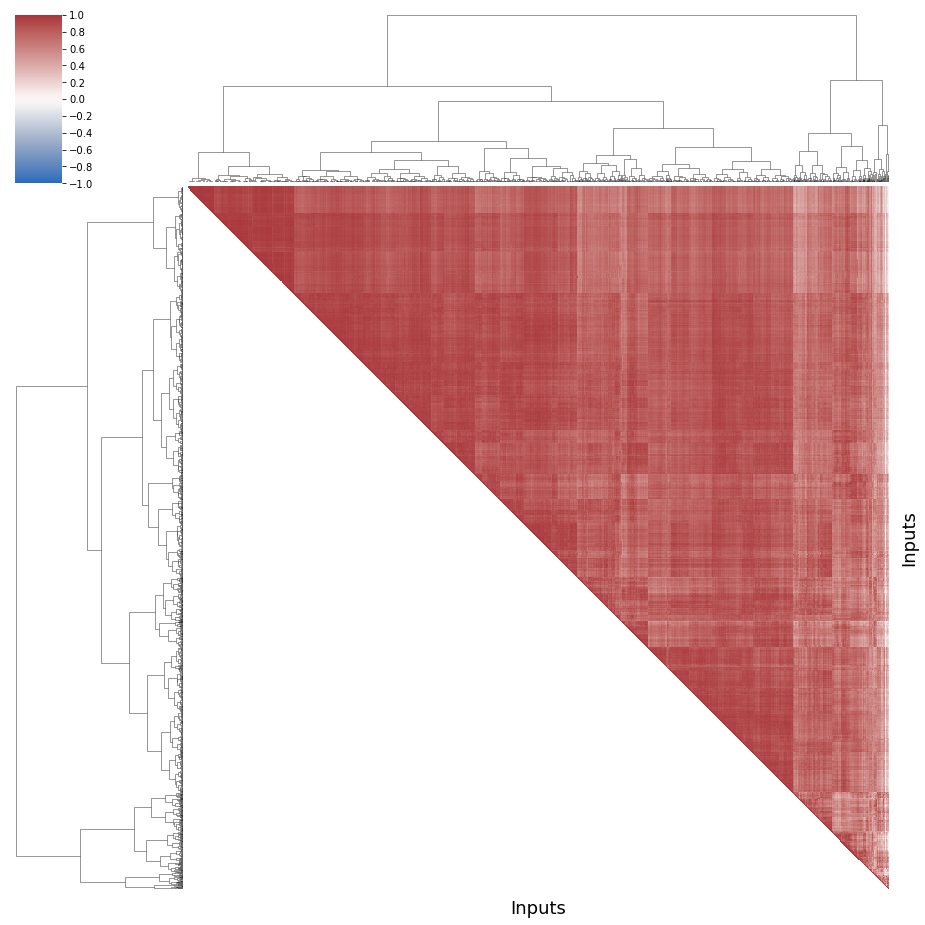

In [29]:
corr = plot_correlationmatrix_dendogram("x264", "cpu")

In [30]:
describe(corr)

count    975106.00
mean          0.79
std           0.13
min          -0.31
25%           0.74
50%           0.82
75%           0.88
max           1.00
dtype: float64

for cpu, correlations are moderate (0.79 on average, first quartile 0.74) while there are negative correlations. Hence the input sensitivity is more important than for encoding time or fps 

#### Encoded size of video

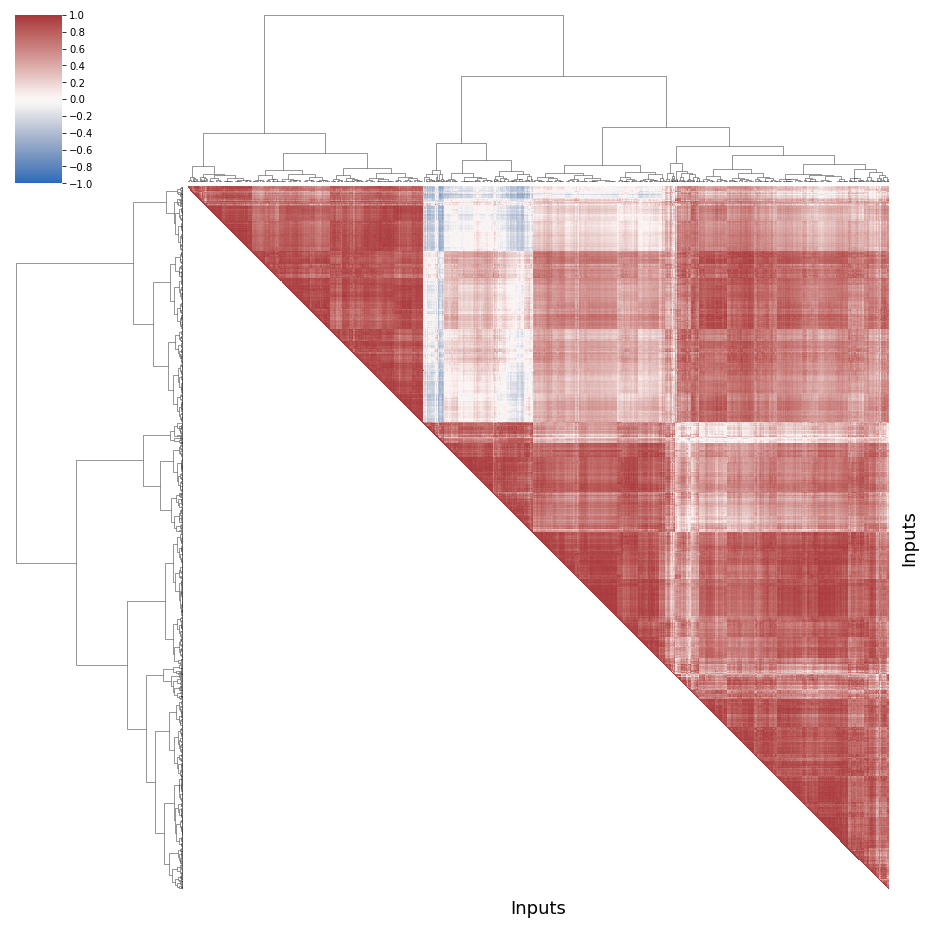

In [31]:
corr = plot_correlationmatrix_dendogram("x264", "size")

In [32]:
describe(corr)

count    975106.00
mean          0.57
std           0.29
min          -0.69
25%           0.39
50%           0.63
75%           0.79
max           1.00
dtype: float64

For encoding size, the input sensitivity is also high and quite similar to bitrate. 

We conducted an additional study for encoding size: we investigate the performances of two extreme configurations: the most and least sensitive to input videos.

Since it is not possible to directly compare two input performance distributions, for all the videos, we sort the n configurations of our dataset w.r.t. their increasing performances and assign a rank to each configuration (i.e. 1 being the smallest and n the largest values) so we can compare their rank between videos.

The rankings of sizes for the configuration 200 are stable, whatever the video; 92.5% of them are between 105 and 130. 

Oppositely, configuration 16's rankings strongly vary across inputs. They are chaotic configurations in terms of performances.

There is no global trend for this configuration (Q1: 54, Q2:103, Q3: \num{171}). It can be both one of the best configurations for minimizing the size (e.g. for video 147 or 551) or one of the worst (e.g. for 109 or 1281).

It then seems very difficult to apply any learning method to rank algorithms on such a configuration.
This would also prevent an \xdeux user to know whether the configuration 16 would be optimal to get the minimal size of video.

#### Encoding time

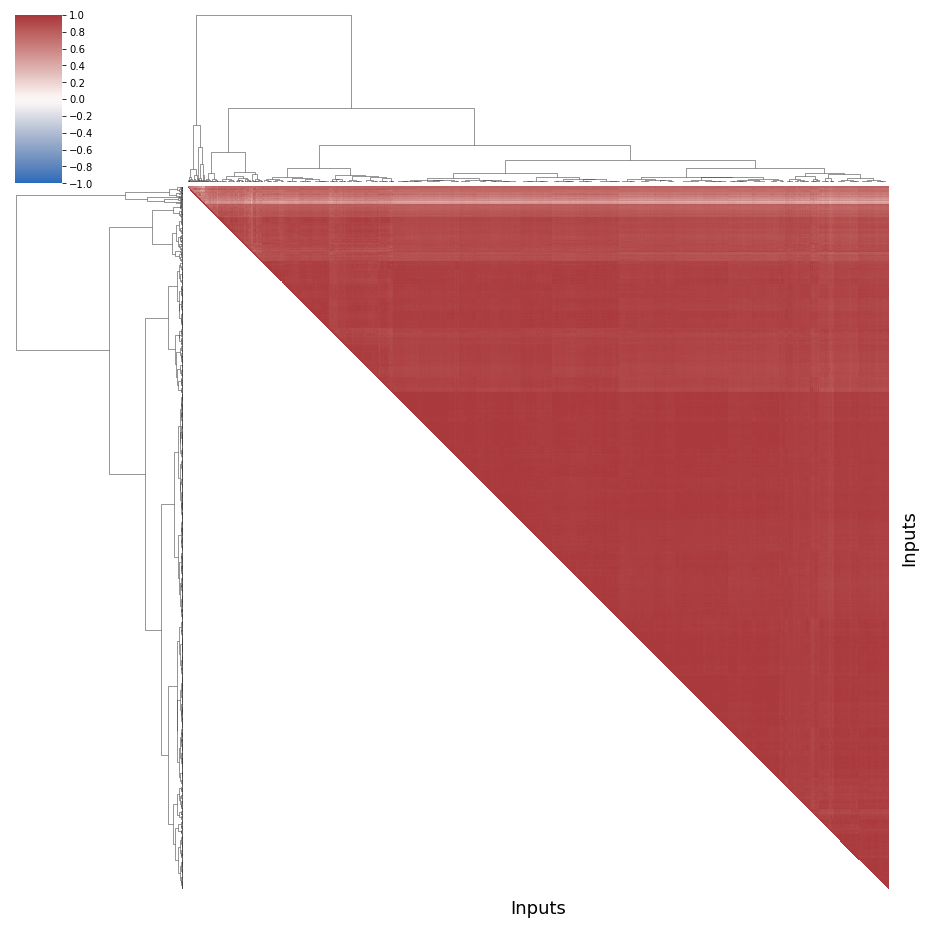

In [33]:
corr = plot_correlationmatrix_dendogram("x264", "etime")

In [34]:
describe(corr)

count    975106.00
mean          0.93
std           0.08
min           0.02
25%           0.93
50%           0.96
75%           0.97
max           1.00
dtype: float64

for encoding time, we observe very strong correlations (0.93 on average and for first quartile). 

Though there are some exceptions among pairs of videos with very low correlations (0.15), the input sensitivity is low for this property.